## Solar farm insolation calculation

In [25]:
# Create a graph of hourly insolation
import math
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

### Declination of earth vs Sun is changing from winter to summer:
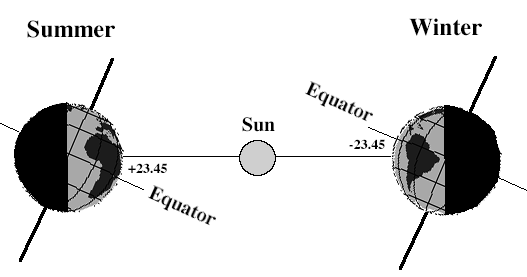

In [26]:
# Constants
declinationC = 23.45 # +/- degrees of variation over the year

In [34]:
# Helper functions
def sinD(x):
    return math.sin(math.radians(x))
def cosD(x):
    return math.cos(math.radians(x))
def tandD(x):
    return math.tan(math.radians(x))
def asinD(x):
    return math.degrees(math.asin(x))
def acosD(x):
    return math.degrees(math.acos(x))
def sinhD(x):
    return math.sinh(math.radians(x))
def coshD(x):
    return math.cosh(math.radians(x))
    
# Declination assuming a perfect circle of earth around the sun (360/365 fixes the position on that orbit)
def declination(dayOfYear):
    return declinationC * sinD(360/365 * (dayOfYear - 81))
    
# Sunrise and sunset
def sunRiseSet(latitude, declination, d):
    rValue = -1 * sinD(latitude) * sinD(declination) / (cosD(latitude) * cosD(declination))
    try:
        rValue = acosD(rValue) / 15
    except Exception as e: # A complex number makes no sense in our model
        return [0,0]
    return [12 - rValue - d / 60, 12 + rValue - d / 60]

# Calculate elevation of the sun (0 when sunrise or sunset, max depends on declination)
def elevation(declination, latitude, d):
    return asinD(sinD(declination) * sinD(latitude) + cosD(declination) * cosD(latitude) * cosD(d))

# Calculate air mass
def airMassSimple(angleV):
    return 1 / cosD(angleV)

# Calculate air mass intensity (kW/m²)
def airMassIntensity(airMass):
    try:
        return 1.353 * math.pow(0.7, math.pow(airMass, 0.678))
    except Exception as e: # A negative airMass will lead to a complex value which makes no sense, set it to 0!
        return 0

# Calculate Solar Insolation (theoretical value)
def solarInsolation(latitude, day, hourAngle):
    decl = declination(day)
    elev = elevation(decl, latitude, hourAngle)
    aMas = airMassSimple(90 - elev)
    aMIt = airMassIntensity(aMas)
    return aMIt

# Convert time (local) to hour angle
def timeToHourAngle(time):    
    return time.hour + time.minute / 60 + time.second / 3600

In [35]:
# Test of functions
pF = False #print log
# Variables >>>=========
latitude = 34.965144 # Equator = 0, poles = +/-90
dayOfYear = 220 # 1st Jan of a year
# <<<============
declinationOnADay = declination(dayOfYear)
print(declinationOnADay)
sunRiseSetPair = sunRiseSet(latitude, declinationOnADay, 0)
print(sunRiseSetPair)
solarInsolationV = np.empty((0, 2), dtype=float)
for timeOfDay in range(400):
    dayFraction = 24 * timeOfDay / 400
    timeFraction = 15 * (dayFraction - 12)
    elevationValue = elevation(declinationOnADay, latitude, timeFraction)
    if pF: print(elevationValue)
    airMassValue = airMassSimple(90 - elevationValue)
    if pF: print(airMassValue)
    airMassIntensityValue = airMassIntensity(airMassValue)
    if pF: print(airMassIntensityValue)
    # Record in np-array
    solarInsolationV = np.append(solarInsolationV,np.array([[dayFraction,airMassIntensityValue]]), axis = 0)

15.964136452236028
[5.230683058063307, 18.769316941936694]


## Output of Solar Insolation for a given day of year and latitude

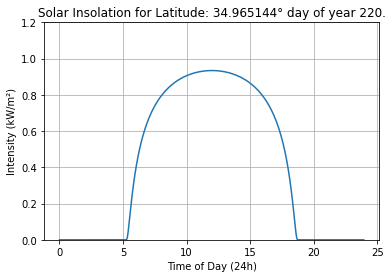

In [36]:
#print(solarInsolation)
fig, ax = plt.subplots()
daytime, intensity = np.split(solarInsolationV, 2, axis = 1)
ax.plot(daytime, intensity)

ax.set(xlabel='Time of Day (24h)', ylabel='Intensity (kW/m²)',
       title='Solar Insolation for Latitude: ' + str(latitude) + '° day of year ' + str(dayOfYear) + '.')
ax.set_ylim([0,1.2])
ax.grid()

#fig.savefig("test.png")
plt.show()

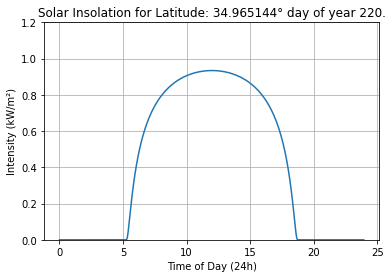

In [59]:
# Test solar insolation (combined function)
sIV = np.empty((0, 2), dtype=float)
interval = 400
for timeOfDay in range(interval): # 6 minute steps
    dayFraction = 24 * timeOfDay / interval
    hourAngle = 15 * (dayFraction - 12) # 15 = 360°/24h
    sI = solarInsolation(latitude, dayOfYear, hourAngle)
    sIV = np.append(sIV,np.array([[dayFraction,sI]]), axis = 0)

# Figure output    
fig, ax = plt.subplots()
daytime, intensity = np.split(sIV, 2, axis = 1)
ax.plot(daytime, intensity)
ax.set(xlabel='Time of Day (24h)', ylabel='Intensity (kW/m²)',
       title='Solar Insolation for Latitude: ' + str(latitude) + '° day of year ' + str(dayOfYear) + '.')
ax.set_ylim([0,1.2])
ax.grid()
plt.show()

In [41]:
# Test single value output
localTime = datetime.now()
hourAngle = timeToHourAngle(localTime)
print(hourAngle)
sI = solarInsolation(latitude, dayOfYear, hourAngle)
print(sI)

8.223888888888888
0.932087825877684


## Cloudiness model - Cloudiness is measured as 0% (no clouds) to 100% (overcast)
There are not many studies accessible that show the clear relation of cloudiness to PV production but this could help:

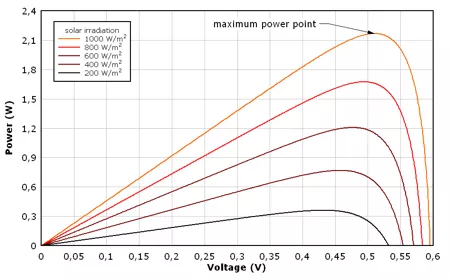

https://solarlove.org/solar-cell-model-and-its-characteristics/

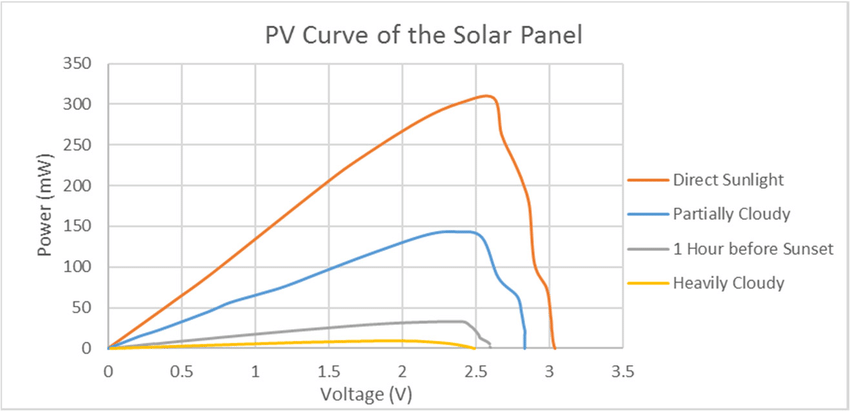

https://www.researchgate.net/figure/a-Current-voltage-IV-curve-of-the-solar-panel-b-power-voltage-PV-curve-of-the_fig2_313275915

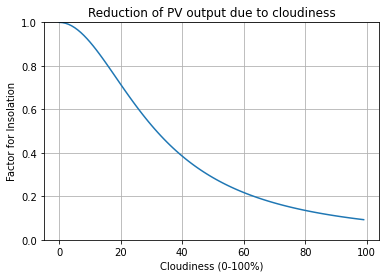

In [72]:
# Proposed model: f(x) = 1/(1+ax²) + b (for R0+)
# clouds from 0 to 100
def cloudinessFactor(clouds, a = 10, b = 0):
    return 1 / (1 + a * math.pow((clouds/100),2)) + b

# Test of function
cOut = np.empty((0, 2), dtype=float)
for c in range(100):
    cF = cloudinessFactor(c)
    cOut = np.append(cOut,np.array([[c,cF]]), axis = 0)

print 
# Figure output    
fig, ax = plt.subplots()
cloudiness, cloudOutput = np.split(cOut, 2, axis = 1)
ax.plot(cloudiness, cloudOutput)
ax.set(xlabel='Cloudiness (0-100%)', ylabel='Factor for Insolation',
       title='Reduction of PV output due to cloudiness')
ax.set_ylim([0,1])
ax.grid()
plt.show()

## 